In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import t04_utils as util

# 1: The bicycle model (car-like vehicle)

<img src="https://git.wur.nl/koots006/msc_course_robotics/raw/main/pictures/fig4_1.svg" width=500>

The picture to the left gives the vehicle model. We assume a car model (the closed boxes), which can be simplified to a bicycle model (the open boxes). This allow to ignore the width of the vehicle. The length $L$, also called the wheel base, is a relevant parameter defining the model.

The origin of the vehicle is in the middle of the rear wheels, which is at position $(x,y)$. The vehicle's heading is defined by the angle $\theta$. The vehicle can change heading using the steering wheels, with a steering angle, $\gamma$. And it has a speed, $v$.

If the steering angle $\gamma \ne 0$, the vehicle rotates around the point ICR. This point is the intersection of the perpendicular line through the rear wheel and the perpendicular line through the steering wheel.

The state of the vehicle at time $t$ is $s_t = [x,y,\theta]$, holding the position, $(x,y)$ (in m), and the heading, $\theta$ (in rad), of the vehicle. 

This vehicle has a velocity that is only forwards/backwards (in the $x$-direction of the robot) and not lateral ($y$-direction). That is:

$$
{}^B \textbf{v} = \left(v,0)\right),
$$
where $B$ is the body coordinate frame of the robot.
This assumption makes the robot **non-holonomic**, meaning that it cannot move in all possible directions.

The **kinematic model** relates the controls of the robot ($\gamma$ and $v$) to the linear velocity $\dot{x}$ and $\dot{y}$ and to the angular velocity $\dot{\theta}$. 

For the bicycle model, the kinematic model is:

$$
\color{blue}{
\begin{matrix}
\dot{x} =& v \cos \theta \\
\dot{y} =& v \sin \theta \\
\dot{\theta} =& \frac{v}{L}\tan \gamma
\end{matrix} }
$$
with $\dot{x}$ and $\dot{y}$ in $\mathrm{m\cdot s}^{-1}$ and $\dot{\theta}$ in $\mathrm{rad\cdot s}^{-1}$.

There are a few constraints that we add to the model:
* A maximum speed: $v < 5$
* A limit on the steering angle: $\gamma \in [-1, 1]$

In this section, we will implement the kinematic model and use it to visualize the trajectory of the robot.

**Exercise:**
* In the code block below, you can find a skeleton for a function to implement the kinematic model for the bicycle model. Finish the code based on the equations provided above.
    * As input
        * `state` is a numpy array of length 3 containing: $[x_t, y_t, \theta_t]$
        * `v` is the linear velocity, $v$
        * `g` is the steering angle $\gamma$
        * `L` is the wheel base $L$
    * As output
        * The numpy array `[dx, dy, dt]` containing $[\dot{x}_t, \dot{y}_t, \dot{\theta}_t]$
        * The velocity `v` and steering angle `g` used.

In [3]:
def bicycle(state, v, g, L, vmax=5, gmax=1):
    """
    Working function...
    """
    # state contains [x_t, y_t, theta_t]
    x_t, y_t, theta_t = state[0],state[1],state[2]
    
    # Set the limits on the speed and the steering angle
    v = np.clip(v, 0, vmax) # velocity
    g = np.clip(g, -gmax, gmax) # steering anagle
    
    # Get the linear and angular velocities (xdot, ydot, theta_dot)
    dx = v*np.cos(theta_t)
    dy = v*np.sin(theta_t)
    dt = (v/L)*np.tan(g)
    
    return np.array([dx, dy, dt]), v, g
# Check
# state = np.array([1,2,1.8])
# print(bicycle(state,2,.2,.4))

The bicycle model calculates the linear and angular velocities at time $t$: $[\dot{x}_t, \dot{y}_t, \dot{\theta}_t]$. Based on these velocities, the next state can be calculated using the so-called *Euler integration scheme*:

$$
\mathbf{s}_{t+1} = \mathbf{s}_t + \dot{\mathbf{s}}_t \cdot \Delta t
$$
which, split up for the individual elements of the state vector is:

$$
x_{t+1} = x_t + \dot{x}_t \cdot \Delta t \\
y_{t+1} = y_t + \dot{y}_t \cdot \Delta t \\
\theta_{t+1} = \theta_t + \dot{\theta}_t \cdot \Delta t,
$$
where $\Delta t$ is the time step.

**Exercise:**
* The function below calculates the sequence of states defining the trajectory of the robot based on a velocity profile `V` and a profile for the steering angle `G`.
* Study the function to find where the above equations are calculated

In [4]:
def simBicycle(state_0, time, V, G, L):
    # time is an array that goes from the start to the end time based on a time step
    # state_0 is an array =  this array defines the starting pose

    # states defines what the pose would be at a specific point in time. So this is an array
    ## That would basically be the length of the number of time points registerd and then an array
    ## indicating the three points defining the pose x,y,theta would be within the sub array.
    states = np.zeros((len(time)+1, 3)) 

    # So now at the first array in states  that is set equal to be the state_0. This means 
    ### This is because state_0 defines in the starting pose for the robot position. 
    ### This then needs to be logged within the states array for the other poses to be based off of the initial
    states[0,:] = state_0
    # Then simplified to say that the initial pose state_0 is equal to a value state
    state = state_0
    # Then defined the time step by subtracting the first time from the second time.
    dT = time[1]-time[0]

    
    for i,(t,v,g) in enumerate(zip(time,V,G)): # the zip combines time, V and G at each instance in time into a array of arrays ( each time has a velocity and )
        # so first computes values for the dx,dy, and dtheta and also return v and g to be used
        vel, v, g = bicycle(state, v, g, L)
        # then for each of the velocities that were computed they were multiplied by the dT
        ## in addition ot this it ad added to the state and then set equal to the state
        ## This is in order to set the new pose 
        state += vel*dT
        ## Now within the states array based on the current position in time set that part of the array
        ## to be the current pose state that was computed above.
        states[i+1,:] = state

    return(states)

The code below performs a simulation of the bicycle model given:
* a profile for the velocity `V`$=\{v_1, \ldots, v_T\}$ and steering angle `G`$=\{\gamma_1, \ldots, \gamma_T\}$. 
* the time step for the simulation (default: `dT` = 0.1s) and the total duration of the simulation (default: `T` = 10s). 
* the wheel length `L`.
* the starting pose `state_0` = $[0,0,0]$
* the profile for the velocity and steering angle is the same as in Fig 4.3 in the book. The velocity is fixed, set to 1.0, and the steering angle is first 0.0 (straight), the 0.5 (left turn), 0.0, -0.5 (right turn) and 0.0.

**Exercise:**
* Check the content of the matrix `states`. How many rows and how many columns does it contain and what are the meanings of the different rows and columns?
* Change the profiles for the velocity and steering angle and observe the resulting trajectory of the robot. Make sue that the lenght of the arrays `V` and `G` are of the same length as `time` (default: 100)
* Make a profile that makes the robot drive in a rectangle with left turns (approximately 90-degree angles is ok).
* Change the wheel length `L` to a larger number. Before you do, think what the consequence of that will be. Also try a lower number.



101


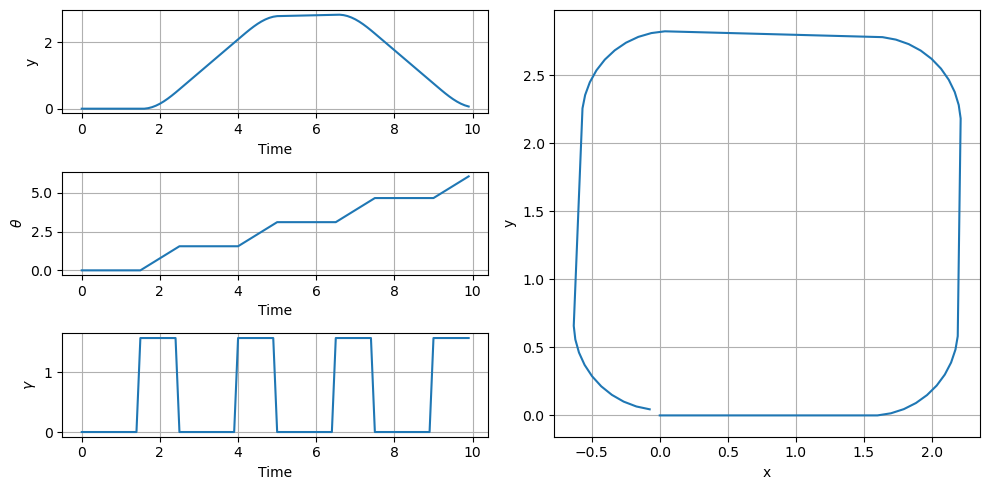

In [5]:
# HOW TO DO RECTANGLE PART?

dT = 0.1  # The time step for simulation
T = 10    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Set the profiles for speed and the steering angle 
V = np.full(len(time),1.0)
## hstack takes a bunch of arrays and basically appends them all together
### The np.full defines an array of np.full(length of array, value ) where value is every value in the array
#### np.full will only have one value in the array.
#G = np.hstack((np.full(30, 0), np.full(10,0.5), np.full(10,0), np.full(10,-0.5), np.full(40,0)))

# Steering Angle for left turns to make rectangle
## 100 is total length so start with length of 20 at 0 angle then do array for 1 with .5 angle then do array of 29 with zero angle, then do 
G = np.hstack((np.full(15,0),np.full(10,np.pi/2),np.full(15,0),np.full(10,np.pi/2),np.full(15,0),np.full(10,np.pi/2),np.full(15,0), np.full(10,np.pi/2)))
#G = np.hstack((np.full(2,0),np.full(1,.5),np.full(2,0),np.full(1,.5),np.full(2,0),np.full(1,.5),np.full(3,0)))
# Set the wheel base
L = 1

# Initialize the state
state_0 = np.array([0.0,0.0,0.0])

# Run the simulation
## States is a 101 x 3 matrix. so each instance in time has a 1x3 matrix in it
## each of these matricies has the first idx representing the velocity in x direction
## the second representing velocity in y
## the third representing angular velocity
states = simBicycle(state_0, time, V, G, L)

print(len(states))
# Show the output of the simulation
util.showTrajectoryBicycle(time, states, G)

calc rotational angle an time



# 2: Controler to move to a goal position

Consider the problem of moving to a point $(x^*,y^*)$. With a **proportional (P) controller**, we can set the velocity proportional to the distance (or position error) from the goal:

$$
v^* = K_v \sqrt{\left(x^*-x\right)^2+\left(y^*-y\right)^2},
$$

where $K_v>0$ is the gain for the velocity control.

To control the steering angle, we need to look at the angle of the goal relative to the robot, which is:

$$
\theta^* = \tan^{-1}\frac{y^*-y}{x^*-x}
$$
This can then be used for a proportional controller for the steering angle, which is proportional to the heading error:

$$
\gamma = K_h\left(\theta^* \circleddash \theta\right)
$$
where $K_h>0$ is the gain for the heading control and $\circleddash$ is the angular difference, which ensures to be in the interval $[-\pi,\pi)$.


Let's take this model in practice:

**Exercise**
* The function `controllerToPoint()` below forms a basis for you to implement the controller to move to a point. Implement the function using these hints:
    * Calculate the distance from the current position of the robot (in `state[0:2]`) to the goal position.
    * Calculate the heading form the robot towards the goal. This is $\theta^*$ in the equations above
    * Calculate the desired velocity `v`, which is $v^*$ in the equations above
    * The calculation of the steering angle $\gamma$ is already given using the function `angdiff` to get an angle in $[-\pi,\pi)$.
    * Run the code and see if the right `v,g` are printed (1.118, 1.855). If not, you made an error in the previous that you need to correct

In [6]:
def angdiff(a, b):
    r = (b - a) 
    if (r >= np.pi):
        r -= 2*np.pi
    elif (r < -np.pi):
        r += 2*np.pi
    return r

def controllerToPoint(goal, state, Kv, Kh):
    # Calculate the distance and heading towards the goal
    x_star,y_star= goal
    x,y = state[0:2]
    x_diff =(x_star - x)
    y_diff = (y_star - y)
    d = np.sqrt(x_diff**2 + y_diff**2)
    print(d)
    # steering angle....
    h = np.arctan2(y_diff, x_diff)
    
    # Calculate the desired velocity proportional to the distance error
    v = Kv*d
    # Calculate the steering angle proportional to the heading error
    g = Kh * angdiff(state[2], h)
    
    return v,g

# To test the function. The output should be (1.118, 1.855)
goal = np.array([5.0,5.0])

state = np.array([7.0,6.0,np.pi])
Kv = 0.5
Kh = 4
v, g = controllerToPoint(goal, state, Kv, Kh)
print(v,g)

2.23606797749979
1.118033988749895 1.8545904360032246


Now that we implemented the controller, we can test it. In the code below, a goal is set at $(5,5)$ and the robot's initial position is at $(8,5)$. Using the gains $K_v=0.5$ and $K_h=4$, and a wheel length $L=1$, the trajectory of the robot over 10s with a time step of 0.1s is shown.

**Exercise:**
* Run the code. You see the robot's trajectory on the left, with the color n the trajectory indicating time, from 0 (dark blue) to T (dark red). The velocity and steering angle over time are on the right.
* Look at the velocity and steering angle over time, what do you see?
* What do you expect will happen when the gain for the heading $K_h$ is lowered to $K_h=1$? Try it.
* Put the gain back to $K_h=4$. 
* Try a higher and lower gain for the velocity $K_v$. Which differences do you see? 
* Put it back to $K_v=0.5$.
* Move the goal closer to the robot, at $(7,5)$, and see what happens. Can you explain this? Does it help if you increase $K_h$? Why not?
* Decrease the wheel base $L$. Can the target now be reached?

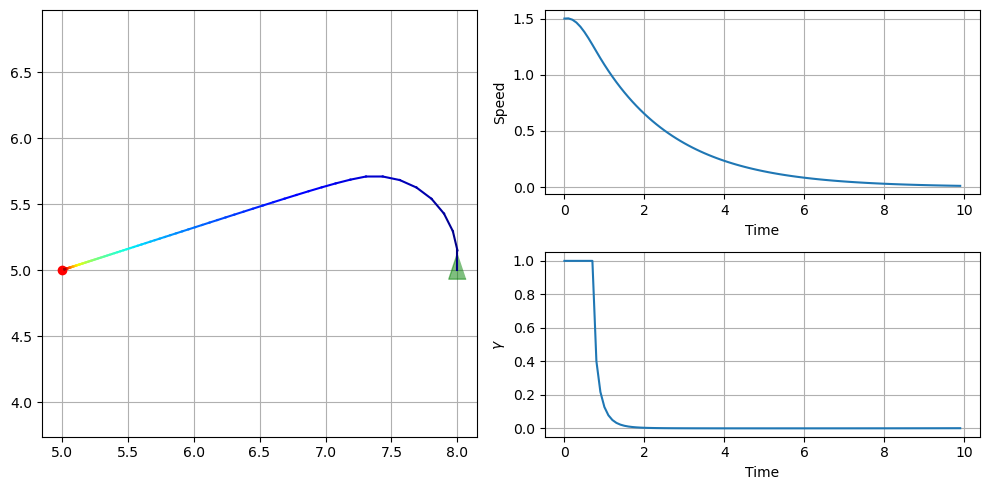

In [ ]:
goal = np.array([5.0,5.0])
state_0 = np.array([8.0,5.0,np.pi/2])

dT = 0.1  # Time step
T = 10    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Set the velocity gain and the heading gain
Kv = 0.5
Kh = 4

# The wheel base
L = 1

# Array to store the states over time
states = np.zeros((len(time)+1, 3))
states[0,:] = state_0
state = state_0.copy()
# Arrays to store the controls
V = np.zeros(len(time))
G = np.zeros(len(time))

for i,t in enumerate(time):
    ### THE CONTROLLER ###    
    v,g = controllerToPoint(goal, state, Kv, Kh)
    ######################
    
    # Put these controls in the bicycle model and observe the new state
    vel, v, g = bicycle(state, v, g, L)
    state += vel*dT
    states[i+1,:] = state

    # Store the velocity and steering angle for later displaying
    V[i]=v
    G[i]=g
    
# Show the trajectory
util.plotTrajectoryGoal(time, states, goal, V, G)


1. What do you expect will happen when the gain for the heading $K_h$ is lowered to $K_h=1$? Try it. 


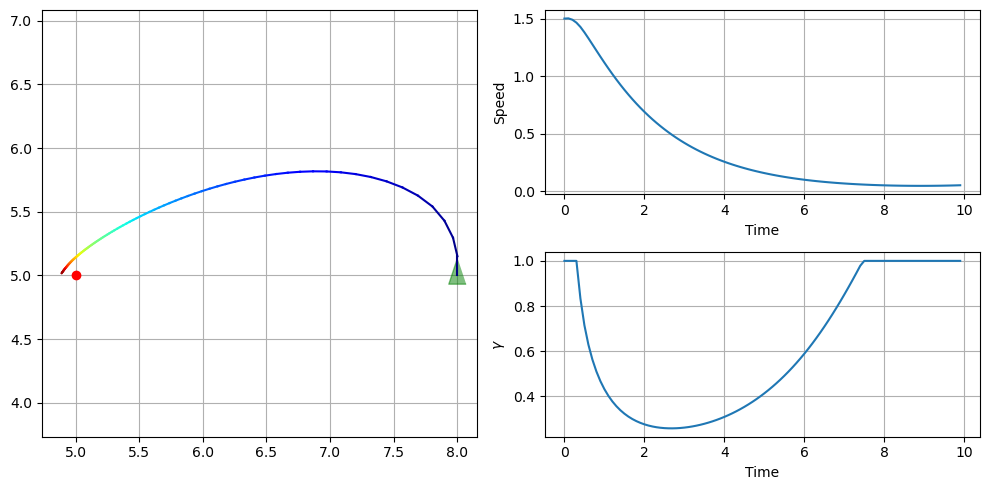

In [ ]:
goal = np.array([5.0,5.0])
state_0 = np.array([8.0,5.0,np.pi/2])

dT = 0.1  # Time step
T = 10    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Set the velocity gain and the heading gain
Kv = 0.5
Kh = 1

# The wheel base
L = 1

# Array to store the states over time
states = np.zeros((len(time)+1, 3))
states[0,:] = state_0
state = state_0.copy()
# Arrays to store the controls
V = np.zeros(len(time))
G = np.zeros(len(time))

for i,t in enumerate(time):
    ### THE CONTROLLER ###    
    v,g = controllerToPoint(goal, state, Kv, Kh)
    ######################
    
    # Put these controls in the bicycle model and observe the new state
    vel, v, g = bicycle(state, v, g, L)
    state += vel*dT
    states[i+1,:] = state

    # Store the velocity and steering angle for later displaying
    V[i]=v
    G[i]=g
    
# Show the trajectory
util.plotTrajectoryGoal(time, states, goal, V, G)

It seems tha the steering angle instead of remaining low comes back up to 1. And the trajectory is more of a half circle type form

2. Try a higher and lower gain for the velocity $K_v$. Which differences do you see? 

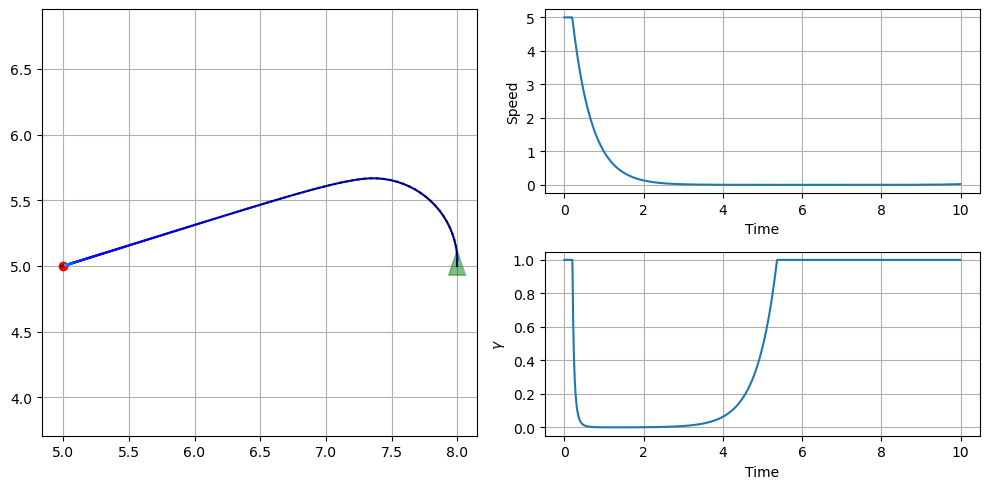

In [88]:
goal = np.array([5.0,5.0])
state_0 = np.array([8.0,5.0,np.pi/2])

dT = 0.01  # Time step
T = 10    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Set the velocity gain and the heading gain
Kv = 2
Kh = 4

# The wheel base
L = 1

# Array to store the states over time
states = np.zeros((len(time)+1, 3))
states[0,:] = state_0
state = state_0.copy()
# Arrays to store the controls
V = np.zeros(len(time))
G = np.zeros(len(time))

for i,t in enumerate(time):
    ### THE CONTROLLER ###    
    v,g = controllerToPoint(goal, state, Kv, Kh)
    ######################
    
    # Put these controls in the bicycle model and observe the new state
    vel, v, g = bicycle(state, v, g, L)
    state += vel*dT
    states[i+1,:] = state

    # Store the velocity and steering angle for later displaying
    V[i]=v
    G[i]=g
    
# Show the trajectory
util.plotTrajectoryGoal(time, states, goal, V, G)

It seems to be going a much larger distance over the period of time since the velocity factor is larger. Also it seems that due to this gain that the steering angle 
is initially erratic

4. Move the goal closer to the robot, at $(7,5)$, and see what happens. Can you explain this? Does it help if you increase $K_h$? Why not?


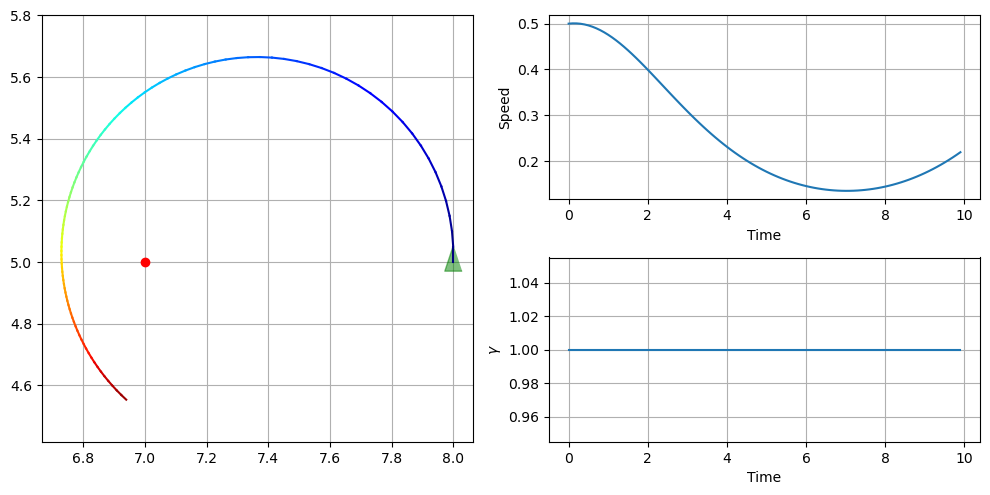

In [92]:
goal = np.array([7.0,5.0])
state_0 = np.array([8.0,5.0,np.pi/2])

dT = 0.1  # Time step
T = 10    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Set the velocity gain and the heading gain
Kv = .5
Kh = 8

# The wheel base
L = 1

# Array to store the states over time
states = np.zeros((len(time)+1, 3))
states[0,:] = state_0
state = state_0.copy()
# Arrays to store the controls
V = np.zeros(len(time))
G = np.zeros(len(time))

for i,t in enumerate(time):
    ### THE CONTROLLER ###    
    v,g = controllerToPoint(goal, state, Kv, Kh)
    ######################
    
    # Put these controls in the bicycle model and observe the new state
    vel, v, g = bicycle(state, v, g, L)
    state += vel*dT
    states[i+1,:] = state

    # Store the velocity and steering angle for later displaying
    V[i]=v
    G[i]=g
    
# Show the trajectory
util.plotTrajectoryGoal(time, states, goal, V, G)

Changing kh doesnt let the robot reach its target it is not on the path to reach the target...


5. Decrease the wheel base $L$. Can the target now be reached

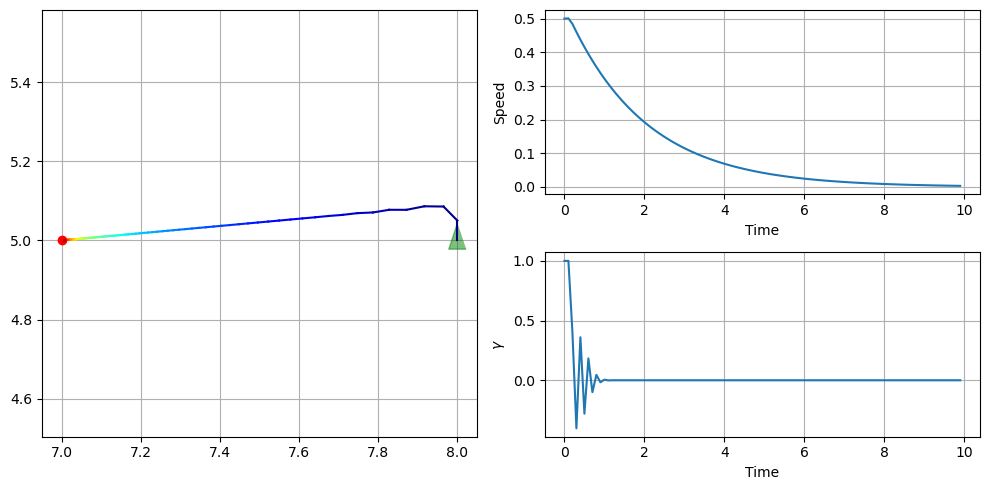

In [ ]:
goal = np.array([7.0,5.0])
state_0 = np.array([8.0,5.0,np.pi/2])

dT = 0.1  # Time step
T = 10    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Set the velocity gain and the heading gain
Kv = .5
Kh = 4

# The wheel base
L = .1

# Array to store the states over time
states = np.zeros((len(time)+1, 3))
states[0,:] = state_0
state = state_0.copy()
# Arrays to store the controls
V = np.zeros(len(time))
G = np.zeros(len(time))

for i,t in enumerate(time):
    ### THE CONTROLLER ###    
    v,g = controllerToPoint(goal, state, Kv, Kh)
    ######################
    
    # Put these controls in the bicycle model and observe the new state
    vel, v, g = bicycle(state, v, g, L)
    state += vel*dT
    states[i+1,:] = state

    # Store the velocity and steering angle for later displaying
    V[i]=v
    G[i]=g
    
# Show the trajectory
util.plotTrajectoryGoal(time, states, goal, V, G)

Decreasing the wheelbase successfully allowed the robot to reach the target! so this means that it was able to make the sharp turn necessary in order to reach the target which it was unable to do perviously based on the restriction based on its construction

# 3: Controller to follow a line

Another useful task for a mobile robot is to follow a line, for instance when navigating through crop rows. We define a line on the ground plane by $ax+by+c=0$. To follow this line, we need two controllers to adjust the steering:

1. **Line-approaching controller**:
This controller makes the robot turn towards the line to minimize the distance between the robot and the line. This requires to calculate the distance $d$ of the position of the robot $(x,y)$ perpendicular to the line, which can be calculated as:<br><br>
$$
d = {ax+by+c \over \sqrt{a^2+b^2}}
$$
To then calculate the requires steering angle for this controller:<br><br>
$$
\alpha_d=-K_d \cdot d
$$
with the gain on the distance-to-line controller $K_d>0$.


2. **Line-parallelling controller**:
This controller adjusts the orientation of the robot to align the robot with the direction of the line. The direction of the line can be calculated with:<br><br>
$$
\theta^* = \tan^{-1}\frac{-a}{b}
$$
This controller then calculates the required steering angle as:<br><br>
$$
\alpha_h = K_h \left(\theta^* \circleddash \theta \right),
$$
where the line-heading gain is $K_h>0$.
<br><br>

The total steering controller is then:

$$
\gamma = \alpha_d + \alpha_h = -K_d \cdot d + K_h \left(\theta^* \circleddash \theta \right)
$$

The speed for this line-following controller is set to a constant speed:

$$
v^* = v_c
$$

**NB** During the Boe-bot project, you will need to implement a similar controller to follow crop row. Where here in the tutorial, we assume that the position of the robot and the equation of the line in world coordinates is known, in the project, the distance to the line, $d$, and the heading with respect to the line, $\left(\theta^* \circleddash \theta \right)$, are calculated based on the distance sensors of the robot.

**Exercise:**
* The function `controllerFollowLine()` below implements the line-following controller. Finish the code based on the equations above. Some hints:
    * For $\sqrt{\ldots}$, you can calculate with `np.sqrt(...)`.
    * To have a quandrant-aware inverse tangens functin, use: `np.arctan2(...)`

In [ ]:
def controllerFollowLine(line, state, Kd, Kh, v = 1):
    # Controller to follow a line with fixed speed v
    
    # Unpack the line equation
    a,b,c = line
    x,y,th = state
    
    # Calculate the distance to the line and the orientation of the line
    d = (a*x + b*y +c)/(np.sqrt(a**2 + b**2))
    ## current orientation
    h = np.arctan2(y,x)
     
    # Calculate the steering angle from the first controller (line approaching) # LINEAPPROACHING
    a_d = -1*Kd*d
    # Calculate the steering angle from the second controller (line paralleling)
    a_h = Kh * angdiff(th,h)
    
    # Get the steering angle for the overall controller
    g = a_d + a_h
    
    return(v,g)

In the code below, the controller is used in a simulation. 

**Exercise:**
* Some successful experiments
    * In lines 2-9, set the line $[a,b,c] = [1, -2, 4]$, starting pose $(x,y, \theta) = (5,2,\frac{\pi}{4})$ and gains for the controller $K_d = 0.5$ and $Kh = 1.0$ and run the simulation.
    * Try different starting points as in Fig 4.7 in the book: $(8,5,\frac{\pi}{2}), (5,8,\pi), (2,5,-\frac{\pi}{2})$ and observe the behavior
    * In crease and decrease the gain $K_d$. What do you observe? Do the same for $K_h$.
* When it fails:
    * Set the start pose to $(10,-2,0)$ and put the gains back to the defaults $K_d = 0.5$ and $Kh = 1.0$. What do you see? What could be the reason that the robot does not reach the line? Pay attention to the distance to the line $d$ and the influence thereof on the line-approaching controller. 
    * Play with the gain for that controller, $K_d$ to let the robot follow the line. 
    * What would be a better solution to deal with this so that we don't have to tune the gain depending on the starting point?
* Different lines:
    * The line has a direction $\tan^{-1}\frac{-a}{b}$. For the previous $[a,b,c] = [1, -2, 4]$ line, this gives a direction of $-0.78$ rad, which is in the third quadrant, meaning that the robot will go diagionally down and towards the left. To make the robot follow the same line in the other direction, you have to reverse the line with $[a,b,c] = [-a,-b,-c]$. Do so and see if th robot now follows the line diagonally upwards and to the right.
    * Try a few other line equations.

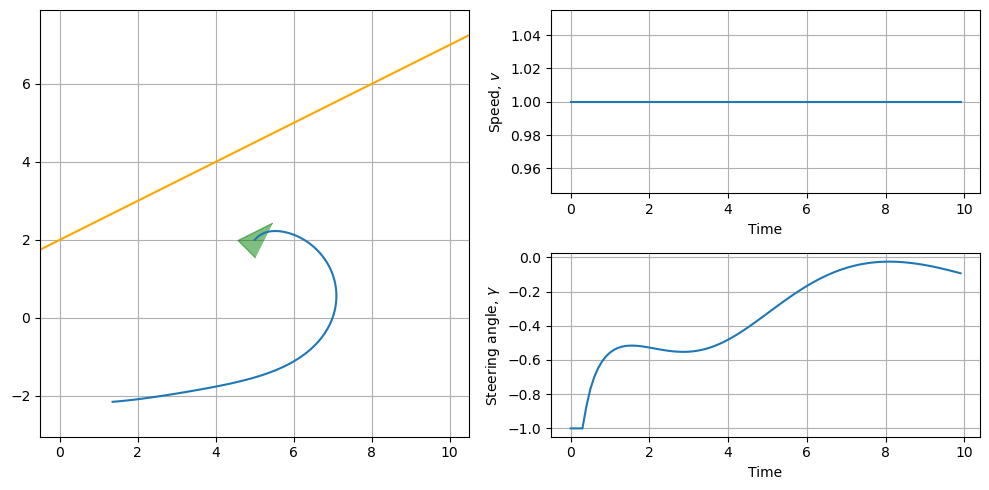

In [ ]:
# Set the line equation
a = 1
b = -2
c = 4
line = np.array([a,b,c])
# Set the starting point
x = 5
y = 2
th = np.pi/4
state_0 = np.array([x,y,th])

# Gains for the line-following controller
Kd = .5  # Gain for the line-approach controller
Kh = 1  # Gain for the line-parallelling controller

# The wheel base
L = 1
# Fixed velocity 
v = 1

# Time (sample time and toral duration) for the simulation
dT = 0.1
T = 10    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Array to store the states over time
states = np.zeros((len(time)+1, 3))
states[0,:] = state_0
state = state_0.copy()
# Arrays to store the controls
V = np.zeros(len(time))
G = np.zeros(len(time))

# Run the simulation
for i,t in enumerate(time):
    ### THE CONTROLLER ###    
    v,g = controllerFollowLine(line, state, Kd, Kh, v)
    ######################
    
    # Put these controls in the bicycle model and observe the new state
    vel, v, g = bicycle(state, v, g, L)
    state += vel*dT
    states[i+1,:] = state
    
    # Store the velocity and steering angle for later displaying
    V[i]=v
    G[i]=g

# Show the trajectory
util.plotTrajectoryLine(time, states, line, V, G)

# 4: Controller to follow a trajectory

For more complex behavior, it might be impotant for a robot to follow a trajectory, that is, a timed sequenced of points on the xy-plane. Such a trajectory can be predefined, or coming from a motion planner (see later tutorials). For now, we assume that the trajectory is provided.

In this controller, we assume a moving goal $(x^*_t,y^*_t)$ that moves along the trajectory with a fixed velocity. We can then use the controller that we used in section 2 of this tutorial to move to the moving goal position, pursuit point.

We want the robot to maintain a distance $d^*$ behind the persuit point, which results in the following tracking error:

$$
e = \sqrt{ \left(x^*-x \right)^2 + \left(y^*-y \right)^2} - d^*
$$

This tracking error is used to determine the velocity, speading up when the robot lacks behind, or slowing down if it is too far. Because the goal is moving, a proportional control is not so useful, as this assumes a stationary point. Instead, we will use a **proportional-integral (PI) controller**, which adds an integral part to the velocity controller:

$$
v^* = K_v e + K_i \int e \, dt
$$

To control the steering angle, we will use the same controller as used to move to a point, that is:
To control the steering angle, we need to look at the angle of the goal relative to the robot, which is:

$$
\theta^* = \tan^{-1}\frac{y^*-y}{x^*-x}
$$

$$
\gamma = K_h\left(\theta^* \circleddash \theta\right)
$$

In the function `controllerToPointPI(...)` below, we will implement the PI-controller to follow a trajectory:
**Excercise:** 
* In this controller, we assume a moving goal that the robot needs to follow. Explain why it is now important to have the integral part adde to the controller.
* Finish the code in the function below to implement the controller. Some tips:
    * The distance $d^*$ from the pursuit point is `dd` in the function
    * `controllerToPointPI.i` is a so called persistent variable, that we will use to update the integral of the error $\int e \, dt$. It has been implemented for you already.
    * for `v`, calculate $v^*$
    * for `h`, calculate $\theta^*$, the desired heading
    * for `g`, calculate $\gamma$

In [ ]:
def controllerToPointPI(goal, state, Kv, Ki, Kh, dT, dd = 0.1):
    # Calculate the error (= distance) to the pursuit point, taking dd into account
    x_star,y_star= goal
    x,y = state[0:2]
    theta = state[2]
    x_diff =(x_star - x)
    y_diff = (y_star - y)
    d = np.sqrt(x_diff**2 + y_diff**2)
    e = d - dd
    
    # For the velocity controller:
    # Get the propotional and the integral part
    # Note that we store the integral part as an attribute of the function 
    #      for persistent memory (we need to get the integral sum)
    controllerToPointPI.i += e * dT  

    v = Kv*e + Ki*controllerToPointPI.i

    
    # For the steering controller
    # Calculate the distance and heading towards the goal
    h = np.arctan2(y_diff,x_diff)
    
    g = Kh * angdiff(theta,h)
    
    return v,g

Integral is needed in order to find the tracking error over a certain region



**Exercise:**
* In the code block below, the controller is tested. Note that with `controllerToPointPI.i = 0`, the integral part of the controller is initialized to zero. 
* Run the code and see if the robot can follow the trajectory (dashed red line).
* You will see that the speed drops when the robot gets near the waypoint. Can you explain why?
* Try some different trajectories by changing the waypoints. The function `util.trajectoryGenerator()` takes the waypoints to create a trajectory of goal locations for every time step, with equal distance between all goal locations. 
* Try some different gains and observe the differences


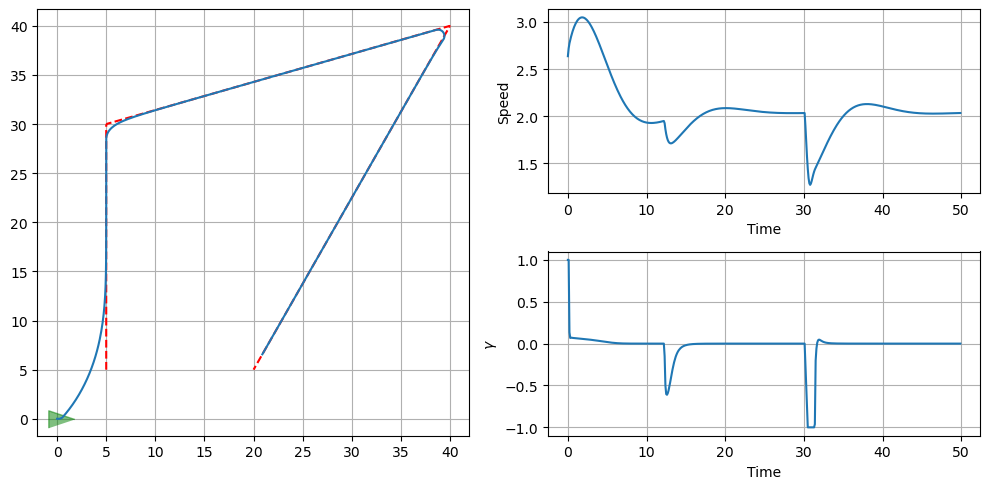

In [ ]:
##########################################
# Code to test the trajectory controller #
##########################################

# Set the initial pose of the robot
state_0 = np.array([0.0,0.0,0.0])

# Total time and time steps for sampling
dT = 0.1
T = 50    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Get the moving goal trajectory
waypoints = np.array([[5,5], [5,30], [40,40], [20,5]])
Goal = util.trajectoryGenerator(waypoints, T, len(time))

# Set the velocity gain and the heading gain
Kv = 0.5
Ki = 0.2
Kh = 4

# The wheel base
L = 1



# Array to store the states over time
states = np.zeros((len(time)+1, 3))
states[0,:] = state_0
state = state_0.copy()
# Arrays to store the controls
V = np.zeros(len(time))
G = np.zeros(len(time))

# Set the integral part of the PI controller to 0
controllerToPointPI.i = 0

for i,t in enumerate(time):
    # Calculate the moving goal target
    goal = Goal[i,:]

    
    ### THE CONTROLLER ###    
    v,g = controllerToPointPI(goal, state, Kv, Ki, Kh, dT, dd=2)
    ######################
        
    # Put these controls in the bicycle model and observe the new state
    vel, v, g = bicycle(state, v, g, L)
    state += vel*dT
    states[i+1,:] = state
    
    # Store the velocity and steering angle for later displaying
    V[i]=v
    G[i]=g

    
# Show the trajectory
util.plotTrajectoryMovingGoal(time, states, Goal, V, G)

The robot does seem to be abel to follow the dashed line. The plot on the left shows the x,y coordinate plane...

There is a drop in speed as it reaches the waypoint. This is because of the fact that due to the time of acceleration for getting around the corner the robot will go slower around this bed with there being a defined time that it has to navigate around this.



Try some different trajectories by changing the waypoints. The function `util.trajectoryGenerator()` takes the waypoints to create a trajectory of goal locations for every time step, with equal distance between all goal locations. 

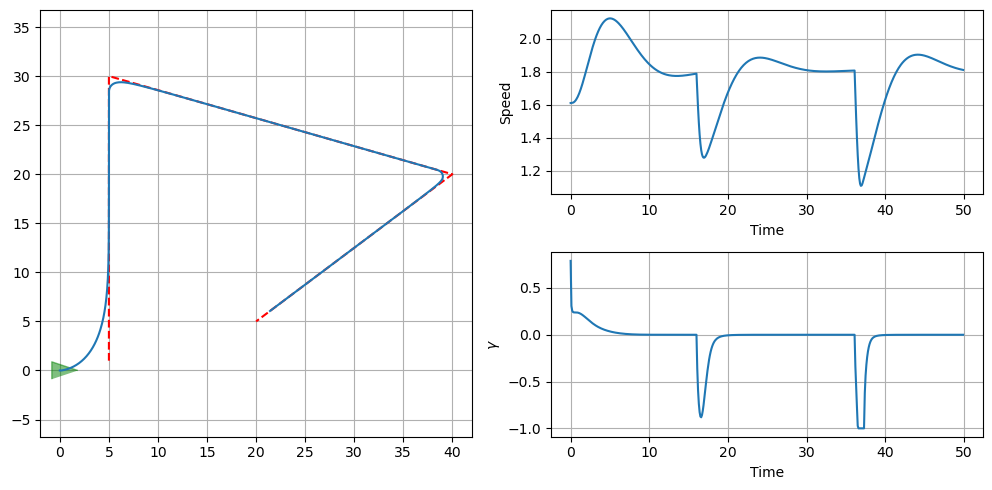

In [ ]:
##########################################
# Code to test the trajectory controller #
##########################################

# Set the initial pose of the robot
state_0 = np.array([0.0,0.0,0.0])

# Total time and time steps for sampling
dT = 0.1
T = 50    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Get the moving goal trajectory
waypoints = np.array([[5,1], [5,30], [40,20], [20,5]])
Goal = util.trajectoryGenerator(waypoints, T, len(time))

# Set the velocity gain and the heading gain
Kv = 0.5
Ki = 0.2
Kh = 4

# The wheel base
L = 1



# Array to store the states over time
states = np.zeros((len(time)+1, 3))
states[0,:] = state_0
state = state_0.copy()
# Arrays to store the controls
V = np.zeros(len(time))
G = np.zeros(len(time))

# Set the integral part of the PI controller to 0
controllerToPointPI.i = 0

for i,t in enumerate(time):
    # Calculate the moving goal target
    goal = Goal[i,:]

    
    ### THE CONTROLLER ###    
    v,g = controllerToPointPI(goal, state, Kv, Ki, Kh, dT, dd=2)
    ######################
        
    # Put these controls in the bicycle model and observe the new state
    vel, v, g = bicycle(state, v, g, L)
    state += vel*dT
    states[i+1,:] = state
    
    # Store the velocity and steering angle for later displaying
    V[i]=v
    G[i]=g

    
# Show the trajectory
util.plotTrajectoryMovingGoal(time, states, Goal, V, G)

# 5: The unicycle model (differential drive)

**TODO: Include Fig 4.14**
<img src="https://git.wur.nl/koots006/msc_course_robotics/raw/main/pictures/fig4_14.svg" width=500>

The car-like vehicles have a relatively complex mechanical structure. Robots with differential steering (differential drive) are simpler and therefore more common. The simpelest systems have two wheels, one right and one left, which can move the robot forwards and backwards, and allow to rotate the robot by using different speeds for the left and right wheel. Larger vehicles with differential, that can carry more load, typically have two pairs of wheels at the left and right side with each pair connected to a motor. In practice, robots with two pairs of wheels have some issues with the wheels slipping sideways during turning. However, we ignore that here and assume that the vehicles velocity is by definition $v$ in the vehicle's $x$-direction and zero in the $y$-direction, that is:

$$
{}^B v = \left(v,0 \right)
$$
where $B$ is the robot's coordinate frame, making also this robot **non-holonomic**.

As for the car-like vehicle, the state of the vehicle at time $t$ is $s_t = [x,y,\theta]$, holding the position, $(x,y)$, and the heading, $\theta$, of the robot. The robot has one parameter to describe its structure, which is the wheel width, $W$, the distance between the left and right wheel, sometime also called the wheel base.

The robot rotates around the instantaneous center of rotation, ICR, depending on the velocity of the left wheel, $v_L$, and the velocity of the right wheel, $v_R$. The left wheel moves along an arc with radius $R_L$ and the right wheel moves along an arc with radius $R_R$. 

The velocity $v$ of the vehicle is the average of the velocity of the left and the right wheel:

$$
v = {v_R + v_L \over 2}
$$

The angular velocity $\dot{\theta}$ is:

$$
\dot{\theta} = \frac{v_L}{R_L} = \frac{v_R}{R_R}
$$

As we know that $R_R = R_L + W$, the angular velocity can be describe in terms of both wheel velocities and the wheel length:

$$
\dot{\theta} = {v_R - v_L \over W}
$$

**Exercise:**
* Show that $\dot{\theta} = \frac{v_L}{R_L} = \frac{v_R}{R_R}$ and $R_R = R_L + W$ results in $\dot{\theta} = {v_R - v_L \over W}$

## The unicycle model
This gives the following kinematic model for a differential drive vehicle, also called the **unicycle model**:
<br><br>

$$
\color{red}{
\begin{matrix}
\dot{x} =& v \cos \theta \\
\dot{y} =& v \sin \theta \\
\dot{\theta} =& {v_{\Delta} \over W}
\end{matrix}},
$$
where the difference in left an right wheel velocity $\color{red}{v_{\Delta} = v_R - v_L}$ and the average wheel velocity $\color{red}{v = {v_R + v_L \over 2}}$.

There are some important things to notice:
* The turn rate, $\dot{\theta}$, is independent from the velocity of the vehcile, but proportional to the difference in velocity of right and left wheels.
* This robot can turn on the spot, that is with the velocity of the robot $v=0$, namely when $v_L = -v_R$.

### $v_L$ and $v_R$ from the controller output $(v^*, \gamma)$
Because the controllers that we discussed in section 2-4 calculate the desired velocity $v^*$ and the desired steering angle $\gamma$, we need to also know how this relates to the the velocities of the left and right wheel velocities $v_L$ and $v_R$. By assuming $\gamma = \dot{\theta}$, we can derive the velocities from the equations above:

$$
v_L = v - \frac{1}{2}W\gamma \\
v_R = v + \frac{1}{2}W\gamma \\
$$

**Exercise:**
* Based on the equations above, finish the kinematic unicylcle model below.
    * As input
        * `state` is a numpy array of length 3 containing: $[x_t, y_t, \theta_t]$
        * `v` is the linear velocity, $v$
        * `g` is the steering angle $\gamma$
        * `W` is the wheel base $W$
    * As output
        * The numpy array `[dx, dy, dt]` containing $[\dot{x}, \dot{y}, \dot{\theta}]$


In [ ]:
def unicycle(state, v, g, W, vmax=5):
    v = np.clip(v, -vmax, vmax)

    # Calculate the left and right velocities from the control inputs
    vL = v - (.5*W*g) # generates array fo the left velocity
    vR = v + (.5*W*g) # generates array for the right velocity
    
    # Set the limits on the speeds of both wheels
    vL = np.clip(vL, -vmax, vmax)
    vR = np.clip(vR, -vmax, vmax)

    # Calculate the linear and angular velocities
    theta = state[2]
    dx = v*np.cos(theta)
    dy = v*np.sin(theta)
    v_delta = vR- vL
    dt = v_delta/W
    
    return np.array([dx, dy, dt]), v, g

**Exercise:**
* Copy-paste the code from section 4 that is marked with `# Code to test the trajectory controller #` and change the bicycle model for the unicycle model. Does the robot now drive the correct path?

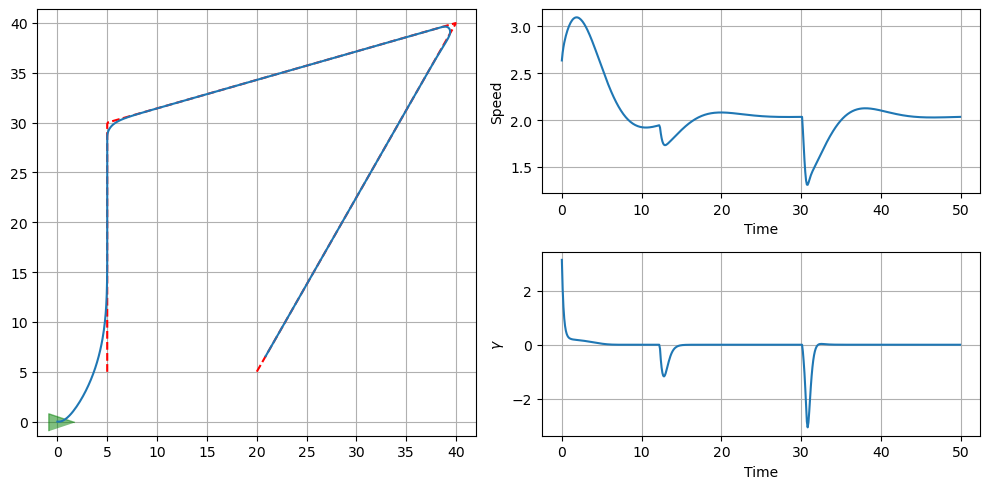

In [ ]:
# Set the integral part of the PI controller to 0
controllerToPointPI.i = 0

# Total time and time steps for sampling
dT = 0.1
T = 50    # Number of seconds to simulate
time = np.arange(0,T,step=dT)

# Set the initial pose of the robot
state_0 = np.array([0.0,0.0,0.0])

# Get the goal trajectory
waypoints = np.array([[5,5], [5,30], [40,40], [20,5]])
Goal = util.trajectoryGenerator(waypoints, T, len(time))

# Set the velocity gain and the heading gain
Kv = 0.5
Ki = 0.2
Kh = 4

# The wheel base
W = 1


# Array to store the states over time
states = np.zeros((len(time)+1, 3))
states[0,:] = state_0
state = state_0.copy()
# Arrays to store the controls
V = np.zeros(len(time))
G = np.zeros(len(time))

    
for i,t in enumerate(time):
    # Calculate the moving goal target
    goal = Goal[i,:]

    
    ### THE CONTROLLER ###    
    v,g = controllerToPointPI(goal, state, Kv, Ki, Kh, dT, dd=2)
    ######################
        
    # Put these controls in the bicycle model and observe the new state
    vel, v, g = unicycle(state, v, g, W)
    state += vel*dT
    states[i+1,:] = state
    
    # Store the velocity and steering angle for later displaying
    V[i]=v
    G[i]=g

    
# Show the trajectory
util.plotTrajectoryMovingGoal(time, states, Goal, V, G)